# 1. Importación de imágenes

Se realiza la importación de imágenes de test mediante la descarga de un zip alojado en el github personal de uno de nosotr@s:

In [1]:
import requests

URL = 'https://github.com/rubengr16/MachineLearning/raw/main/Prac3/test.zip'
# Descarga de los datos a partir de la URL
response = requests.get(URL)
# Abrir la respuesta de la request https para escribir su contenido en el directorio actual
open('test.zip', 'wb').write(response.content)

6203566

Una vez tenemos en nuestro directorio el zip con las imágenes, estas son extraídas mediante la librería zipfile:

In [2]:
import zipfile

with zipfile.ZipFile('test.zip', 'r') as zip_ref:
    zip_ref.extractall('test/')

Realizamos el proceso análogo descargando el zip de train. Lo único que en este caso por el peso del zip hemos tenido que dividirlo, pues github limita los archivos de más de 25MB y en este caso el zip pesaba alrededor de 150MB:

In [3]:
# Iteramos por los 15 zips que han resultado de la división en zips de 10MB como máximo y descargamos cada uno:
for i in range(1, 16):
    number = str(i) if i > 9 else '0' + str(i)
    URL = f'https://github.com/rubengr16/MachineLearning/raw/main/Prac3/train.zip.0{number}'
    response = requests.get(URL)
    open(f'train.zip.0{number}', 'wb').write(response.content)

Mediante una lógica similar extraemos el conjunto de imágenes de train. Sólo que antes de extraerlas, unificamos cada uno de los zips divididos en uno común que pueda extraer la librería zipfile:

In [4]:
import os

for i in range(1, 16):
    # Si el número es menor que 10, por ejemplo el 1 se representará como 01. Mientras que el 13 será 13 tal cual
    number = str(i) if i > 9 else '0' + str(i)
    with open("train.zip", "ab") as f:
        with open(f'train.zip.0{number}', "rb") as z:
            f.write(z.read())

with zipfile.ZipFile('train.zip', "r") as zip_ref:
    zip_ref.extractall('./')

Para no tener zips residuales entre nuestro sistema de archivos, nos deshacemos de aquellos zips que contenían las imágenes después de haberlas extraído:

In [5]:
os.remove('test.zip')
os.remove('train.zip')
for i in range(1, 16):
    number = str(i) if i > 9 else '0' + str(i)
    os.remove(f'train.zip.0{number}')

# 2. Máscara para imágenes y dimensiones

Obtenemos todas las imágenes localizadas en la carpeta train:

In [45]:
import numpy as np
from PIL import Image

entries = os.listdir('train/')

images_dataset = []
for entry in entries:
    image = Image.open(f'train/{entry}')
    images_dataset.append(np.asarray(image))
    
images_dataset = np.array(images_dataset)

Antes de poner las máscaras, debemos asegurarnos de que todas las imágenes del dataset tienen el mismo tamaño, y en caso negativo, redimensionarlas para que así sea.

In [46]:
def dimensiones(list):
    bool = True
    dim = list[0].shape
    for image in list:
        if image.shape != dim:
            bool = False
    if bool:
        print("Todas las imágenes del dataset tienen las mismas dimensiones.")
    else:
        print("No todas las imágenes del dataset tienen las mismas dimensiones.")

Lo ejecutamos:

In [47]:
dimensiones(images_dataset)

Todas las imágenes del dataset tienen las mismas dimensiones.


Por tanto se puede concluir que todas las imágenes tienen las mismas dimensiones.

Para poder comparar con las máscaras vamos a ver la imagen, por ejemplo observamos la de la posición 7

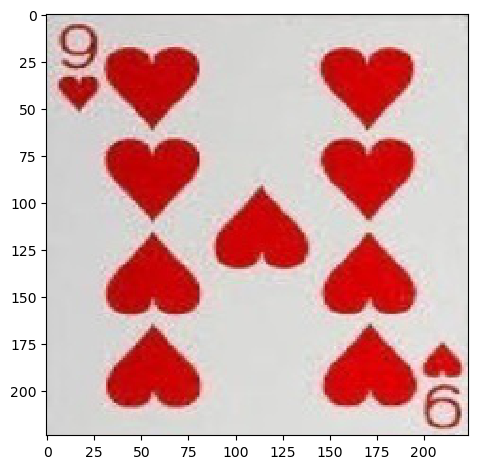

In [6]:
from skimage import io

io.imshow(images_dataset[6])

In [48]:
def mascara(dataset):
    mascara_dataset = dataset.copy()
    for i in range(len(mascara_dataset)):
        foto = mascara_dataset[i]
        foto[:160, 64:224] = 0
        foto[64:224 , :160] = 0
    return mascara_dataset

Aplicamos la máscara:

In [49]:
train_array = mascara(images_dataset)

Comprobamos que se ha logrado aplicar la máscara correctamente:

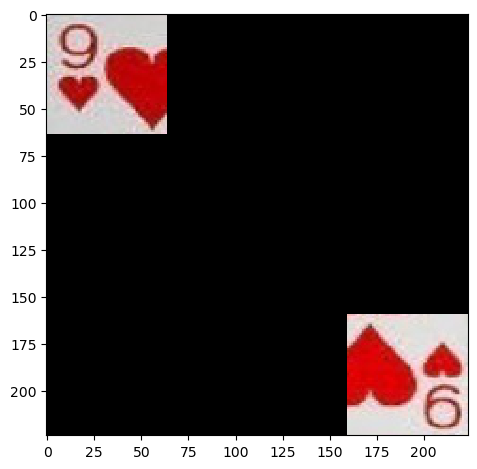

In [9]:
io.imshow(train_array[6])

# 3. Normalización

Iniciamos la normalización. Como sabemos, cada uno de los píxeles que conforman la imagen obtienen su valor de una tupla con 3 elementos que varían del 0 al 255. Cada uno de estos 3 elementos se componen a la intensidad de Red -rojo-, Green -verde- y Blue -azul-, respectivamente. De modo que primero observamos el contenido del train_array[6] antes de la normalización:

In [16]:
train_array[6]

array([[[196, 207, 201],
        [202, 208, 206],
        [205, 207, 206],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[222, 228, 224],
        [212, 216, 215],
        [201, 201, 203],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[211, 211, 211],
        [204, 202, 203],
        [202, 197, 201],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [224, 218, 220],
        [224, 220, 221],
        [222, 220, 221]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [231, 227, 224],
        [229, 225, 222],
        [231, 228, 223]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [228, 224, 221],
        [232, 227, 221],
        [231, 227, 218]]

Creamos una función para normalizar, convirtiendo los valores del array a floats y luego lo dividimos entre el máximo valor posible, es decir 255, de modo que obtengamos valores entre 0 y 1:

In [50]:
def normalizar(array):
    array = array.astype('float32')
    array = array / 255.0
    return array

Normalizamos con la función ya creada:

In [51]:
train_array = normalizar(train_array)

Comprobamos el cambio de valor tras la normalización:

In [18]:
train_array[6]

array([[[0.76862746, 0.8117647 , 0.7882353 ],
        [0.7921569 , 0.8156863 , 0.80784315],
        [0.8039216 , 0.8117647 , 0.80784315],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.87058824, 0.89411765, 0.8784314 ],
        [0.83137256, 0.84705883, 0.84313726],
        [0.7882353 , 0.7882353 , 0.79607844],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.827451  , 0.827451  , 0.827451  ],
        [0.8       , 0.7921569 , 0.79607844],
        [0.7921569 , 0.77254903, 0.7882353 ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       ...,

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0

Mostramos la imagen número 6 para ver que la normalización no ha afectado a lo que representa:

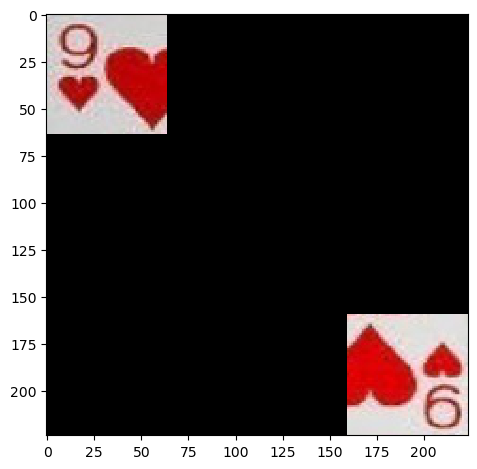

In [19]:
io.imshow(train_array[6])

# 4. Filtros

Para no sesgar los datos de entrada del algoritmo, debemos pasar los datos "en crudo". Sin embargo, lo que sí se puede hacer es reducir el espacio de búsqueda, puesto que es muy grande. Esto ayudará al algoritmo de Machine Learning a encontrar patrones en los datos más fácilmente.

Por tanto, procedemos a aplicar algunos filtros a las imágenes. Lo primero es importar filters de skimage.

In [24]:
from skimage import filters

## Paso a rgb2gray

Puesto que la mayoría de los filtros están pensados para trabajar con escalas de grises, vamos a transformar las imágenes con rgb2gray.

In [52]:
from skimage.color import rgb2gray

def gray_filter(array):
    gray_array = list(array)
    for i in range(len(gray_array)):
        gray_array[i] = rgb2gray(gray_array[i])
    return gray_array

Ejecutamos y mostramos que el cambio se ha llevado a cabo satisfactoriamente.

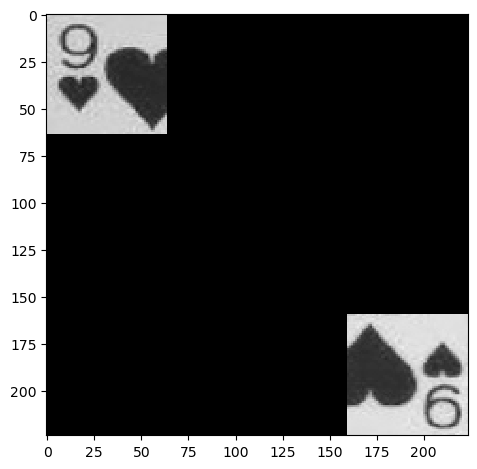

In [53]:
gray_array = gray_filter(train_array)

io.imshow(gray_array[6])

A continuación, podemos usar los distintos filtros. Es posible tanto utilizar uno por separado como combinarlos. Presentamos 10 filtros distintos: gaussian, unsharp_mask, median, sobel, scharr, prewitt, roberts, laplace, frangi y hessian.

## Filtro gaussian

El filtro gaussian permite desenfocar las imágenes.

In [25]:
def gaussian_filter(array):
    sigma = 5.5
    for i in range(len(array)):
        array[i] = filters.gaussian(array[i], sigma=sigma)
    return array

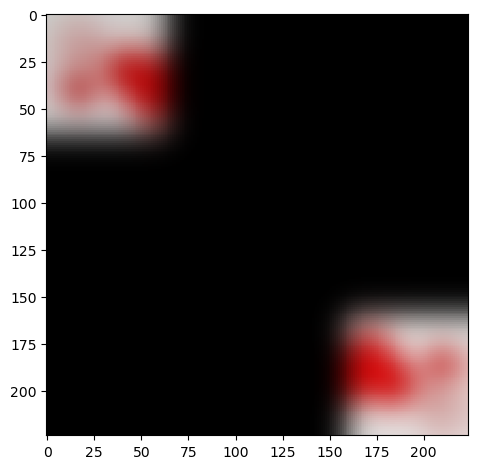

In [29]:
gaussian_array = gaussian_filter(train_array)
io.imshow(gaussian_array[6])

## Filtro unsharp_mask

El filtro unsharp_mask resalta los bordes de la imagen, y además desenfoca las zonas sin bordes.

In [ ]:
def unsharp_mask_filter(array):
    radius = 98.5
    for i in range(len(array)):
        array[i] = filters.unsharp_mask(array[i], radius=radius)
    return array

In [ ]:
u_m_array = unsharp_mask_filter(train_array)
io.imshow(u_m_array[6])

## Filtro median

El filtro median "aplana" la imagen.

In [211]:
def median_filter(array):
    for i in range(len(array)):
        array[i] = filters.median(array[i])
    return array

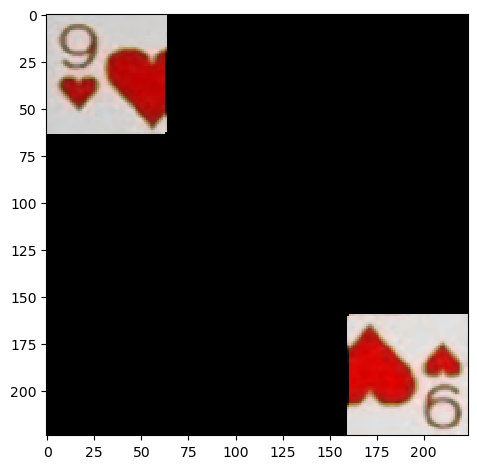

In [212]:
median_array = median_filter(train_array)
io.imshow(train_array[6])

## Filtro sobel

A partir de este filtro, todos se centran en los bordes de las imágenes que, normalmente, es donde residen las principales diferencias. 

In [213]:
def sobel_filter(array):
    for i in range(len(array)):
        array[i] = filters.sobel(array[i])
    return array

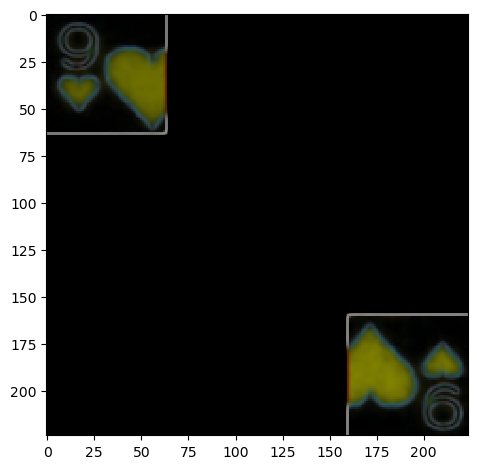

In [214]:
sobel_array = sobel_filter(train_array)
io.imshow(sobel_array[6])

## Filtro scharr

In [33]:
def scharr_filter(array):
    for i in range(len(array)):
        array[i] = filters.scharr(array[i])
    return array

In [ ]:
scharr_array = scharr_filter(train_array)
io.imshow(scharr_array[6])

## Filtro prewitt

In [217]:
def prewitt_filter(array):
    for i in range(len(array)):
        array[i] = filters.prewitt(array[i])
    return array

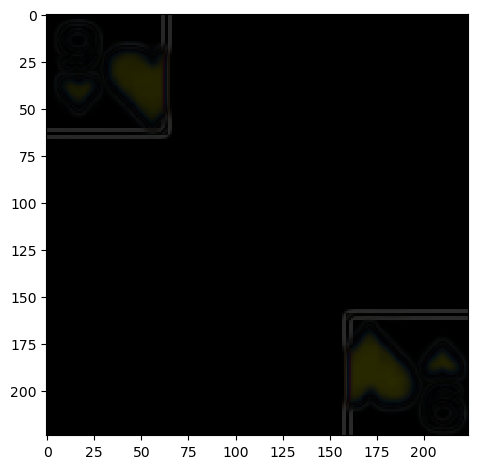

In [218]:
prewitt_array = prewitt_filter(train_array)
io.imshow(prewitt_array[6])

## Filtro roberts

In [34]:
def roberts_filter(array):
    for i in range(len(array)):
        array[i] = filters.roberts(array[i])
    return array

In [ ]:
robert_array = roberts_filter(train_array)
io.imshow(robert_array[6])

## Filtro laplace

In [219]:
def laplace_filter(array):
    for i in range(len(array)):
        array[i] = filters.laplace(array[i])
    return array

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


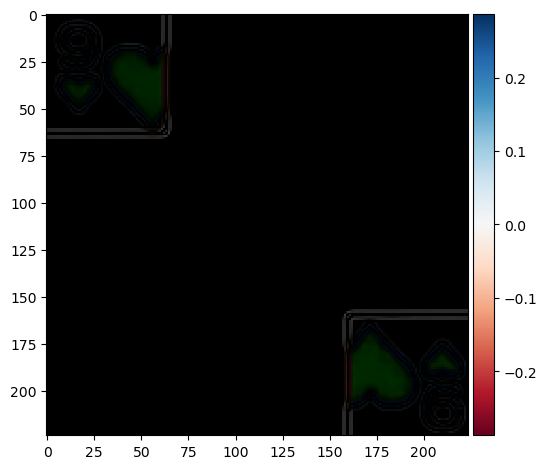

In [220]:
laplace_array = laplace_filter(train_array)
io.imshow(laplace_array[6])

## Filtro frangi

In [38]:
def frangi(array):
    for i in range(len(array)):
        array[i] = filters.frangi(array[i])
    return array

In [ ]:
frangi_array = frangi_filter(train_array)
io.imshow(frangi_array[6])

## Filtro hessian

In [221]:
def hessian_filter(array):
    for i in range(len(array)):
        array[i] = filters.hessian(array[i])
    return array

In [ ]:
hessian_array = hessian_filter(train_array)
io.imshow(hessian_array[6])

C:\Users\User\anaconda3\lib\site-packages\skimage\_shared\utils.py:348: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  return func(*args, **kwargs)


# 5. Redimensionamiento

Cada una de las imágenes está representada por una matriz de 224x224 valores, conteniendo en cada valor un valor o un array con 3 valores -R, G, B-:

In [94]:
from sklearn.decomposition import PCA

def redimensionar(dataset):
    redimension_array = []
    # Obtener la dimensión total de las imágenes
    redimension_size = 1
    for dim in dataset[0].shape:
        redimension_size = redimension_size * dim
    # Redimensión de las imágenes
    for data in dataset:
        redimension_array.append(np.reshape(data, redimension_size))
    # Transformación de los datos a 2 valores para que puedan ser interpretados por el modelo
    pca = PCA(2)
    converted_data = pca.fit_transform(redimension_array)
    return converted_data

Ejecutamos la redimensión:

In [95]:
gray_array = redimensionar(gray_array)

# 6. Clustering

A continuación, vamos a probar nuestro conjunto de entrenamiento con distintos métodos de clustering vistos en clase.

## KMeans

KMeans es un algoritmo de clasificación no supervisado que agrupa objetos en grupos según sus características.

Para utilizar este algoritmo necesitamos un vector de 2 dimensiones como mucho, pero nosotros estamos utilizando una lista, así que la convertiremos en un array con numpy.

In [99]:
import numpy as np

vector = np.array(grey_array)


Aquí reducimos las dimensiones a 2, ya que con las 3 dimensiones (largo de la foto, ancho de la foto, color RGB) no podemos usar el algoritmo.

### MiniBatch

In [101]:
vector = vector.reshape(len(vector), -1)

Nuestra intención era utilizar el algoritmo KMeans, pero eso conllevaría mucho consumo de memoria (que no tenemos), por lo que utilizaremos MiniBatchKmeans, el cual crea los centroides a partir de un número que se le da al invocarlo, mejorando el rendimiento.

In [102]:
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(n_clusters = 5, random_state=0, batch_size = 256)
kmeans.fit(vector)

C:\Users\User\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


MiniBatchKMeans(batch_size=256, n_clusters=5, random_state=0)

Ahora, MiniBatchKMeans ha generado un centroide para cada cluster. Veamos qué centroides ha creado.

In [24]:
kmeans.cluster_centers_

array([[ 9.0893053e-02,  9.7137250e-02, -3.4607086e-02, ...,
         1.9008437e-02,  2.3635264e-02,  2.6847359e-02],
       [-9.8871235e-03,  8.6096938e-05, -3.3918188e-03, ...,
        -8.9013996e-03, -9.0613896e-03, -9.8615084e-03],
       [ 7.8430176e-03,  3.9216876e-03, -3.9215624e-02, ...,
        -1.0931373e-02,  5.6546926e-04,  7.8431368e-03],
       [ 1.7674273e-07, -1.1628433e-02, -7.7524073e-03, ...,
        -3.8758502e-03,  7.7520539e-03, -7.7520539e-03],
       [ 3.1859551e-03, -4.5060171e-03, -8.1226532e-04, ...,
        -4.2293925e-02, -7.7861607e-02, -7.8505255e-02]], dtype=float32)

# 7. Primer intento con filtro de grises

Repetimos todo el proceso realizado para el conjunto de entrenamiento, pero ahora con el conjunto de test.

Cargamos las imágenes del test.

In [104]:
test_entries = os.listdir('test/')

test_dataset = []
for entry in test_entries:
    image = Image.open(f'test/{entry}')
    test_dataset.append(np.asarray(image))
    
test_dataset = np.array(test_dataset)

Confirmamos que se han cargado todas.

In [26]:
len(test_dataset)

265

Comprobamos de nuevo si todas las imágenes tienen las mismas dimensiones.

In [105]:
dimensiones(test_dataset)

Todas las imágenes del dataset tienen las mismas dimensiones.


Añadimos la máscara al conjunto de test.

In [106]:
test_array = mascara(test_dataset)

Y normalizamos los valores.

In [107]:
test_array = normalizar(test_array)

Convertimos las imágenes a color en escala de grises, para que el clustering sean más efectivo.

In [108]:
test_array = gray_filter(test_array)

In [109]:
test_array = redimensionar(test_array)

De nuevo, necesitamos convertir nuestra lista en un vector y redimensionarlo.

In [110]:
vectorTest = np.array(test_array)

In [111]:
vectorTest = vectorTest.reshape(len(vectorTest), -1)

Y, por último, hacemos la predicción con KMeans.

In [112]:
kmeansTest = MiniBatchKMeans(n_clusters = 5, random_state=0, batch_size = 256)
kmeansTest.fit(vector)
predict = kmeansTest.fit_predict(vectorTest)

C:\Users\User\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


array([2, 2, 0, 0, 2, 2, 4, 4, 2, 2, 0, 3, 2, 2, 3, 4, 2, 2, 0, 0, 1, 2,
       0, 1, 2, 2, 0, 2, 3, 3, 0, 0, 0, 0, 3, 2, 2, 1, 2, 2, 2, 4, 0, 0,
       3, 0, 2, 4, 0, 0, 2, 3, 0, 2, 2, 3, 0, 2, 0, 4, 2, 3, 3, 0, 0, 3,
       3, 2, 2, 0, 0, 1, 3, 0, 3, 2, 2, 2, 3, 2, 0, 0, 2, 0, 0, 1, 2, 3,
       0, 0, 4, 0, 2, 4, 0, 3, 3, 0, 2, 2, 0, 2, 0, 0, 0, 0, 2, 4, 0, 2,
       0, 4, 0, 4, 2, 0, 2, 0, 0, 0, 0, 3, 0, 3, 1, 4, 2, 0, 2, 2, 0, 1,
       2, 2, 4, 0, 2, 0, 2, 2, 0, 3, 0, 4, 0, 2, 0, 2, 0, 2, 4, 3, 2, 2,
       0, 0, 0, 0, 0, 3, 2, 3, 2, 1, 2, 3, 2, 3, 0, 4, 2, 0, 3, 2, 0, 2,
       0, 2, 4, 2, 2, 2, 2, 0, 1, 2, 3, 0, 2, 4, 1, 2, 0, 0, 2, 4, 3, 0,
       2, 2, 1, 4, 0, 2, 3, 3, 1, 0, 4, 0, 2, 3, 2, 2, 2, 4, 2, 0, 2, 2,
       0, 3, 0, 0, 0, 0, 2, 4, 4, 2, 2, 0, 2, 3, 0, 2, 2, 1, 3, 3, 2, 0,
       0, 2, 4, 3, 2, 2, 2, 2, 4, 2, 2, 2, 2, 0, 2, 2, 2, 0, 0, 3, 0, 3,
       0])

Creamos una función para obtener los ids de las imágenes sin la extensión de archivo

In [118]:
def clean_paths(entries):
    clean_entries = []
    for i in range(len(entries)):
        clean_entries.append(entries[i][:-4])
    return clean_entries

Ejecutamos la función:

In [119]:
test_entries = clean_paths(test_entries)

Creamos la primera submission:

In [115]:
import pandas as pd

d = {'id': clean_entries, 'suit': predict}
submit = pd.DataFrame(data=d)
submit.to_csv("Prac3_first_approach.csv", index=False)

# 8. Segundo intento con filtro de grises + prewitt

Repetimos todo el proceso realizado añadiendo el filtro prewitt:

Cargamos las imágenes del test.

In [120]:
test_entries = os.listdir('test/')

test_dataset = []
for entry in test_entries:
    image = Image.open(f'test/{entry}')
    test_dataset.append(np.asarray(image))
    
test_dataset = np.array(test_dataset)

Confirmamos que se han cargado todas.

In [121]:
len(test_dataset)

265

Comprobamos de nuevo si todas las imágenes tienen las mismas dimensiones.

In [122]:
dimensiones(test_dataset)

Todas las imágenes del dataset tienen las mismas dimensiones.


Añadimos la máscara al conjunto de test.

In [123]:
test_array = mascara(test_dataset)

Y normalizamos los valores.

In [124]:
test_array = normalizar(test_array)

Convertimos las imágenes a color en escala de grises y el filtro de prewitt, para que el clustering sean más efectivo.

In [125]:
test_array = gray_filter(test_array)
test_array = prewitt_filter(test_array)

In [129]:
test_array = redimensionar(test_array)

De nuevo, necesitamos convertir nuestra lista en un vector y redimensionarlo.

In [130]:
vectorTest = np.array(test_array)

In [131]:
vectorTest = vectorTest.reshape(len(vectorTest), -1)

Y, por último, hacemos la predicción con KMeans.

In [132]:
kmeansTest = MiniBatchKMeans(n_clusters = 5, random_state=0, batch_size = 256)
kmeansTest.fit(vector)
predict = kmeansTest.fit_predict(vectorTest)

C:\Users\User\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


Ejecutamos la función para eliminar las extensiones:

In [134]:
test_entries = clean_paths(test_entries)

Creamos la primera submission:

In [135]:
import pandas as pd

d = {'id': clean_entries, 'suit': predict}
submit = pd.DataFrame(data=d)
submit.to_csv("Prac3_gray_and_prewitt.csv", index=False)

# 9. Tercer intento con filtro de grises + hessian

Repetimos todo el proceso realizado cambiando el filtro prewitt por hessian:

Cargamos las imágenes del test.

In [161]:
test_entries = os.listdir('test/')

test_dataset = []
for entry in test_entries:
    image = Image.open(f'test/{entry}')
    test_dataset.append(np.asarray(image))
    
test_dataset = np.array(test_dataset)

Confirmamos que se han cargado todas.

In [162]:
len(test_dataset)

265

Comprobamos de nuevo si todas las imágenes tienen las mismas dimensiones.

In [163]:
dimensiones(test_dataset)

Todas las imágenes del dataset tienen las mismas dimensiones.


Añadimos la máscara al conjunto de test.

In [164]:
test_array = mascara(test_dataset)

Y normalizamos los valores.

In [165]:
test_array = normalizar(test_array)

Convertimos las imágenes a color en escala de grises y el filtro de prewitt, para que el clustering sean más efectivo.

In [166]:
test_array = gray_filter(test_array)
test_array = hessian_filter(test_array)

In [169]:
test_array = redimensionar(test_array)

De nuevo, necesitamos convertir nuestra lista en un vector y redimensionarlo.

In [170]:
vectorTest = np.array(test_array)

In [171]:
vectorTest = vectorTest.reshape(len(vectorTest), -1)

Y, por último, hacemos la predicción con KMeans.

In [172]:
kmeansTest = MiniBatchKMeans(n_clusters = 5, random_state=0, batch_size = 256)
kmeansTest.fit(vector)
predict = kmeansTest.fit_predict(vectorTest)

C:\Users\User\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


Ejecutamos la función para eliminar las extensiones:

In [173]:
test_entries = clean_paths(test_entries)

Creamos la primera submission:

In [174]:
import pandas as pd

d = {'id': clean_entries, 'suit': predict}
submit = pd.DataFrame(data=d)
submit.to_csv("Prac3_gray_and_hessian.csv", index=False)

# 10. Cuarto intento con filtro de grises + prewitt + hessian

Como ha mejorado la predicción con hessian, vamos a añadirle prewitt antes a ver qué sucede:

Cargamos las imágenes del test.

In [175]:
test_entries = os.listdir('test/')

test_dataset = []
for entry in test_entries:
    image = Image.open(f'test/{entry}')
    test_dataset.append(np.asarray(image))
    
test_dataset = np.array(test_dataset)

Confirmamos que se han cargado todas.

In [176]:
len(test_dataset)

265

Comprobamos de nuevo si todas las imágenes tienen las mismas dimensiones.

In [177]:
dimensiones(test_dataset)

Todas las imágenes del dataset tienen las mismas dimensiones.


Añadimos la máscara al conjunto de test.

In [178]:
test_array = mascara(test_dataset)

Y normalizamos los valores.

In [179]:
test_array = normalizar(test_array)

Convertimos las imágenes a color en escala de grises y el filtro de prewitt, para que el clustering sean más efectivo.

In [180]:
test_array = gray_filter(test_array)
test_array = prewitt_filter(test_array)
test_array = hessian_filter(test_array)

In [181]:
test_array = redimensionar(test_array)

De nuevo, necesitamos convertir nuestra lista en un vector y redimensionarlo.

In [182]:
vectorTest = np.array(test_array)

In [183]:
vectorTest = vectorTest.reshape(len(vectorTest), -1)

Y, por último, hacemos la predicción con KMeans.

In [184]:
kmeansTest = MiniBatchKMeans(n_clusters = 5, random_state=0, batch_size = 256)
kmeansTest.fit(vector)
predict = kmeansTest.fit_predict(vectorTest)

C:\Users\User\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


Ejecutamos la función para eliminar las extensiones:

In [185]:
test_entries = clean_paths(test_entries)

Creamos la primera submission:

In [186]:
import pandas as pd

d = {'id': clean_entries, 'suit': predict}
submit = pd.DataFrame(data=d)
submit.to_csv("Prac3_gray_prewitt_and_hessian.csv", index=False)

# 11. Quinto intento con filtro de grises + median

Como ha mejorado la mezcla entre prewitt y hessian no ha dado ningún buen resultado, decidimos probar ahora con gris y median:

Cargamos las imágenes del test.

In [187]:
test_entries = os.listdir('test/')

test_dataset = []
for entry in test_entries:
    image = Image.open(f'test/{entry}')
    test_dataset.append(np.asarray(image))
    
test_dataset = np.array(test_dataset)

Confirmamos que se han cargado todas.

In [188]:
len(test_dataset)

265

Comprobamos de nuevo si todas las imágenes tienen las mismas dimensiones.

In [189]:
dimensiones(test_dataset)

Todas las imágenes del dataset tienen las mismas dimensiones.


Añadimos la máscara al conjunto de test.

In [190]:
test_array = mascara(test_dataset)

Y normalizamos los valores.

In [191]:
test_array = normalizar(test_array)

Convertimos las imágenes a color en escala de grises y el filtro de prewitt, para que el clustering sean más efectivo.

In [192]:
test_array = gray_filter(test_array)
test_array = median_filter(test_array)

In [193]:
test_array = redimensionar(test_array)

De nuevo, necesitamos convertir nuestra lista en un vector y redimensionarlo.

In [194]:
vectorTest = np.array(test_array)

In [195]:
vectorTest = vectorTest.reshape(len(vectorTest), -1)

Y, por último, hacemos la predicción con KMeans.

In [196]:
kmeansTest = MiniBatchKMeans(n_clusters = 5, random_state=0, batch_size = 256)
kmeansTest.fit(vector)
predict = kmeansTest.fit_predict(vectorTest)

C:\Users\User\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


Ejecutamos la función para eliminar las extensiones:

In [197]:
test_entries = clean_paths(test_entries)

Creamos la primera submission:

In [198]:
import pandas as pd

d = {'id': clean_entries, 'suit': predict}
submit = pd.DataFrame(data=d)
submit.to_csv("Prac3_gray_and_median.csv", index=False)

# 12. Sexto intento con filtro de grises + laplace

Como ha mejorado la predicción con hessian, vamos a añadirle prewitt antes a ver qué sucede:

Cargamos las imágenes del test.

In [199]:
test_entries = os.listdir('test/')

test_dataset = []
for entry in test_entries:
    image = Image.open(f'test/{entry}')
    test_dataset.append(np.asarray(image))
    
test_dataset = np.array(test_dataset)

Confirmamos que se han cargado todas.

In [200]:
len(test_dataset)

265

Comprobamos de nuevo si todas las imágenes tienen las mismas dimensiones.

In [201]:
dimensiones(test_dataset)

Todas las imágenes del dataset tienen las mismas dimensiones.


Añadimos la máscara al conjunto de test.

In [202]:
test_array = mascara(test_dataset)

Y normalizamos los valores.

In [203]:
test_array = normalizar(test_array)

Convertimos las imágenes a color en escala de grises y el filtro de prewitt, para que el clustering sean más efectivo.

In [204]:
test_array = gray_filter(test_array)
test_array = laplace_filter(test_array)

In [205]:
test_array = redimensionar(test_array)

De nuevo, necesitamos convertir nuestra lista en un vector y redimensionarlo.

In [206]:
vectorTest = np.array(test_array)

In [207]:
vectorTest = vectorTest.reshape(len(vectorTest), -1)

Y, por último, hacemos la predicción con KMeans.

In [208]:
kmeansTest = MiniBatchKMeans(n_clusters = 5, random_state=0, batch_size = 256)
kmeansTest.fit(vector)
predict = kmeansTest.fit_predict(vectorTest)

C:\Users\User\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


Ejecutamos la función para eliminar las extensiones:

In [209]:
test_entries = clean_paths(test_entries)

Creamos la primera submission:

In [210]:
import pandas as pd

d = {'id': clean_entries, 'suit': predict}
submit = pd.DataFrame(data=d)
submit.to_csv("Prac3_gray_and_laplace.csv", index=False)

# 13. Clustering Jerárquico Aglomerativo con filtro de grises + prewitt

Ahora cambiamos nuestro modelo de entrenamiento a uno de clustering jerárquico aglomerativo.

Cargamos las imágenes del test.

In [151]:
test_entries = os.listdir('test/')

test_dataset = []
for entry in test_entries:
    image = Image.open(f'test/{entry}')
    test_dataset.append(np.asarray(image))
    
test_dataset = np.array(test_dataset)

Confirmamos que se han cargado todas.

In [121]:
len(test_dataset)

265

Comprobamos de nuevo si todas las imágenes tienen las mismas dimensiones.

In [152]:
dimensiones(test_dataset)

Todas las imágenes del dataset tienen las mismas dimensiones.


Añadimos la máscara al conjunto de test.

In [153]:
test_array = mascara(test_dataset)

Y normalizamos los valores.

In [154]:
test_array = normalizar(test_array)

Convertimos las imágenes a color en escala de grises y el filtro de prewitt, para que el clustering sean más efectivo.

In [155]:
test_array = gray_filter(test_array)
test_array = prewitt_filter(test_array)

In [156]:
test_array = redimensionar(test_array)

De nuevo, necesitamos convertir nuestra lista en un vector y redimensionarlo.

In [157]:
vectorTest = np.array(test_array)

In [158]:
vectorTest = vectorTest.reshape(len(vectorTest), -1)

Y, por último, hacemos la predicción con KMeans.

In [ ]:
from sklearn.cluster import AgglomerativeClustering

agglomerative = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
agglomerative.fit(vector)
predict = agglomerative.fit_predict(vectorTest)

Ejecutamos la función para eliminar las extensiones:

In [ ]:
test_entries = clean_paths(test_entries)

Creamos la primera submission:

In [ ]:
import pandas as pd

d = {'id': clean_entries, 'suit': predict}
submit = pd.DataFrame(data=d)
submit.to_csv("Prac3_agglomerative_grey_and_prewitt.csv", index=False)

# 14. Conclusiones

Entre las distintas posibilidades de clustering, es mejor usar K-Means, usa menos recursos tanto computacionales como temporales. Puesto que en el caso de AgglomerativeClustering tarda demasiado para unos resultados que no acaban de tener la precisión necesaria.
Por otro lado, entre los filtros usados, los mejores son hessian y prewitt por ese orden. Mientras que median y laplace no mejoran la precisión de estos anteriores. Por otro lado, hemos experimentado un gran decremento en la precisión si mezclamos 2 filtros como hessian y prewitt, sin contar con el filtro de grises presente en todas las predicciones.

In [ ]:
io.imshow(gray_array[6])
io.imshow(hessian_array[6])
io.imshow(prewitt_array[6])
io.imshow(median_array[6])
io.imshow(laplace_array[6])
io.imshow(hessian_filter(list(prewitt_array[6])[0])